# ZINB copula approach

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, chi2
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd


import importlib

## Example data

/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


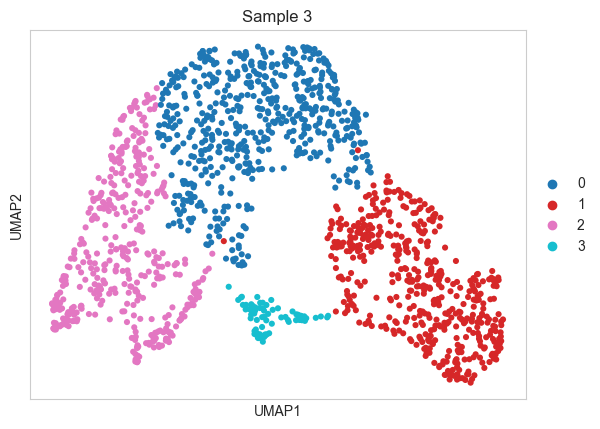

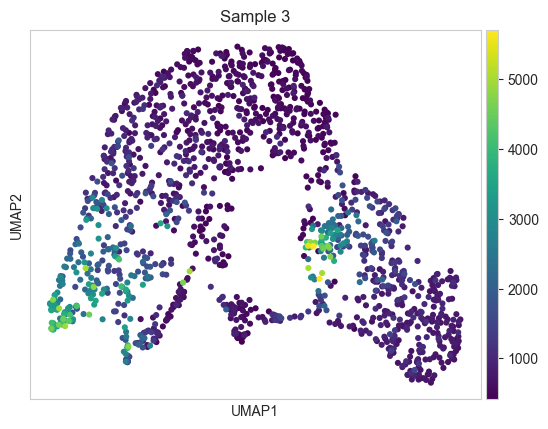

In [2]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

sc.pl.umap(data_gene, color="total_counts", palette="tab10", title="Sample 3", cmap="viridis")
plt.show()

In [3]:
count_table = data_gene.layers["counts"].copy()

In [4]:
from statsmodels.discrete.discrete_model import NegativeBinomialP, NegativeBinomial, Poisson, GeneralizedPoisson
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)

In [5]:
print(data_gene.var["mean_counts"].sort_values(ascending=False).head(10))

PAO1_ID
PA4244    12.582902
PA4264    12.150259
PA4256     9.336140
PA4262     7.246762
PA4260     6.580311
PA4932     5.964378
PA4248     5.772668
PA5559     5.710492
PA4261     5.700777
PA4237     5.041451
Name: mean_counts, dtype: float64


In [7]:
i = 345

dat = count_table[:, i].toarray().T[0]
print(np.mean(dat))
print(np.var(dat))
# sns.histplot(dat)


model_zip = ZeroInflatedPoisson(dat, np.ones(count_table.shape[0]))
res_zip = model_zip.fit(method='bfgs', maxiter=5000, maxfun=5000)
print(res_zip.summary())

model_p = Poisson(dat, np.ones(count_table.shape[0]))
res_p = model_p.fit(method='bfgs', maxiter=5000, maxfun=5000)
print(res_p.summary())

model_zinb = ZeroInflatedNegativeBinomialP(dat, np.ones(count_table.shape[0]))
res_zinb = model_zinb.fit(method='bfgs', maxiter=5000, maxfun=5000)
print(res_zinb.summary())

model_nb = NegativeBinomial(dat, np.ones(count_table.shape[0]))
res_nb = model_nb.fit(method='bfgs', maxiter=5000, maxfun=5000)
print(res_nb.summary())

0.013601036269430052
0.01859739523208677
Optimization terminated successfully.
         Current function value: 0.067028
         Iterations: 11
         Function evaluations: 21
         Gradient evaluations: 21
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                 1544
Model:             ZeroInflatedPoisson   Df Residuals:                     1543
Method:                            MLE   Df Model:                            0
Date:                 Mon, 25 Mar 2024   Pseudo R-squ.:              -1.530e-10
Time:                         08:23:18   Log-Likelihood:                -103.49
converged:                        True   LL-Null:                       -103.49
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. Th

                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:                 1544
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     1543
Method:                                      MLE   Df Model:                            0
Date:                           Mon, 25 Mar 2024   Pseudo R-squ.:                     nan
Time:                                   08:23:18   Log-Likelihood:                -104.04
converged:                                  True   LL-Null:                           nan
Covariance Type:                       nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -3.2604     17.078     -0.191      0.849     -36.732      30.211
const            -4.2611      0.68

/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3938: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/johannes.ostner/opt/anaconda3/envs/BacSC2/lib/python3.11/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: 

## Automatic distribution selection

In [216]:
res_df = pd.DataFrame(index=data_gene.var_names)

res_df["gene_mean"] = np.mean(count_table.toarray(), axis=0)
res_df["gene_var"] = np.var(count_table.toarray(), axis=0)
res_df["mv_diff"] = res_df["gene_mean"] - res_df["gene_var"]
res_df["gene_dist"] = ["nb" if x < 0 else "poi" for x in res_df["mv_diff"]]

print(res_df["gene_dist"].value_counts())
res_df

gene_dist
nb     5144
poi     409
Name: count, dtype: int64


,gene_mean,gene_var,mv_diff,gene_dist
PAO1_ID,,,,
PA0001,0.666451,0.755973,-0.089522,nb
PA0002,0.468912,0.588412,-0.119500,nb
PA0003,0.893782,1.043122,-0.149340,nb
PA0004,0.373705,0.398557,-0.024853,nb
PA0005,0.120466,0.124089,-0.003623,nb
...,...,...,...,...
PA5566,0.009715,0.010916,-0.001201,nb
PA5567,0.126943,0.161347,-0.034404,nb
PA5568,0.659974,0.750315,-0.090341,nb


In [246]:
from scipy.stats import logistic

intercepts = []
overdisps = []
zinf_params = []

for i in range(len(data_gene.var_names)):
    
    if i%100 == 0:
        print(f"gene {i}")

    dat = count_table[:, i].toarray().T[0] 
    dist = res_df["gene_dist"][i]
    
    if dist == "poi":
        overdisps.append(np.inf)
        
        model_zipoi = ZeroInflatedPoisson(dat, np.ones(count_table.shape[0]))
        res_zipoi = model_zipoi.fit(method='bfgs', maxiter=5000, maxfun=5000, disp=0)

        model_poi = Poisson(dat, np.ones(count_table.shape[0]))
        res_poi = model_poi.fit(method='bfgs', maxiter=5000, maxfun=5000, disp=0)
        
        zipoi_loglik = res_zipoi.llf
        poi_loglik = res_poi.llf
        
        stat = 2 * (zipoi_loglik - poi_loglik)
        pvalue = 1 - chi2.ppf(stat, 1)
        
        if pvalue < 0.05:
            intercepts.append(np.exp(res_zipoi.params[1]))
            zinf_params.append(logistic.pdf(res_zipoi.params[0]))
        else:
            intercepts.append(np.exp(res_poi.params[0]))
            zinf_params.append(0.)
            
    elif dist == "nb":
        model_zinb = ZeroInflatedNegativeBinomialP(dat, np.ones(count_table.shape[0]))
        res_zinb = model_zinb.fit(method='bfgs', maxiter=5000, maxfun=5000, disp=0)
        
        model_nb = NegativeBinomialP(dat, np.ones(count_table.shape[0]))
        res_nb = model_nb.fit(method='bfgs', maxiter=5000, maxfun=5000, disp=0)
        
        zinb_loglik = res_zinb.llf
        nb_loglik = res_nb.llf
        
        stat = 2 * (zinb_loglik - nb_loglik)
        pvalue = 1 - chi2.ppf(stat, 1)
        
        if pvalue < 0.05:
            intercepts.append(np.exp(res_zinb.params[1]))
            zinf_params.append(logistic.pdf(res_zinb.params[0]))
            overdisps.append(1/res_zinb.params[2])
        else:
            intercepts.append(np.exp(res_nb.params[0]))
            zinf_params.append(0.)
            overdisps.append(1/res_nb.params[1])

res_df["dist_mean"] = intercepts
res_df["dist_overdisp"] = overdisps
res_df["dist_zinf"] = zinf_params
print(res_df)


gene 0
gene 100
gene 200
gene 300
gene 400
gene 500
gene 600
gene 700
gene 800
gene 900
gene 1000
gene 1100
gene 1200
gene 1300
gene 1400
gene 1500
gene 1600
gene 1700
gene 1800
gene 1900
gene 2000
gene 2100
gene 2200
gene 2300
gene 2400
gene 2500
gene 2600
gene 2700
gene 2800
gene 2900
gene 3000
gene 3100
gene 3200
gene 3300
gene 3400
gene 3500
gene 3600
gene 3700
gene 3800
gene 3900
gene 4000
gene 4100
gene 4200
gene 4300
gene 4400
gene 4500
gene 4600
gene 4700
gene 4800
gene 4900
gene 5000
gene 5100
gene 5200
gene 5300
gene 5400
gene 5500
         gene_mean   gene_var    mv_diff gene_dist  dist_mean  dist_overdisp  \
PAO1_ID                                                                        
PA0001    0.666451   0.755973  -0.089522        nb   0.666451       5.594046   
PA0002    0.468912   0.588412  -0.119500        nb   0.468912       2.098145   
PA0003    0.893782   1.043122  -0.149340        nb   0.893782       6.142604   
PA0004    0.373705   0.398557  -0.024853        nb  

In [247]:
res_df

,gene_mean,gene_var,mv_diff,gene_dist,dist_mean,dist_overdisp,dist_zinf,sim_mean,sim_var
PAO1_ID,,,,,,,,,
PA0001,0.666451,0.755973,-0.089522,nb,0.666451,5.594046,0.0,0.717617,0.828291
PA0002,0.468912,0.588412,-0.119500,nb,0.468912,2.098145,0.0,0.466321,0.630990
PA0003,0.893782,1.043122,-0.149340,nb,0.893782,6.142604,0.0,0.907383,1.108650
PA0004,0.373705,0.398557,-0.024853,nb,0.373705,4.997989,0.0,0.404793,0.431350
PA0005,0.120466,0.124089,-0.003623,nb,0.120466,4.093460,0.0,0.133420,0.138935
...,...,...,...,...,...,...,...,...,...
PA5566,0.009715,0.010916,-0.001201,nb,0.009715,0.078538,0.0,0.014249,0.015341
PA5567,0.126943,0.161347,-0.034404,nb,0.126943,0.446939,0.0,0.134715,0.164494
PA5568,0.659974,0.750315,-0.090341,nb,0.659974,6.270660,0.0,0.658679,0.741660


In [353]:
print(res_df["gene_dist"].unique())

['nb' 'poi']


In [309]:
from scipy.stats import nbinom, poisson, norm
rng = np.random.default_rng(1234)

X = ut.convert_to_dense_counts(data_gene, layer="counts")

n, p = X.shape
new_data_shape = (n, p)

def dist_cdf_selector(X, intercept, overdisp, zinf_param):
    if overdisp == np.inf:
        cdf = poisson.cdf(X, intercept)
    else:
        r, q = nb.negbin_mean_to_numpy(intercept, overdisp)
        cdf = nbinom.cdf(X, r, q)
        
    if zinf_param != 0:
        cdf = zinf_param + (1 - zinf_param) * cdf
        
    return cdf

def dist_ppf_selector(X, intercept, overdisp, zinf_param):
    
    if zinf_param != 0:
        X_ = (X - zinf_param)/(1 - zinf_param)
    else:
        X_ = X
    
    if overdisp == np.inf:
        ppf = poisson.ppf(X_, intercept)
    else:
        r, q = nb.negbin_mean_to_numpy(intercept, overdisp)
        ppf = nbinom.ppf(X_, r, q)
        
    if zinf_param != 0:
        ppf[X < zinf_param] = 0
        
    return ppf


In [310]:
# Do counts-to-uniform transforamation from scDesign
F = np.array([dist_cdf_selector(X[:, j], intercepts[j], overdisps[j], zinf_params[j]) for j in range(p)]).T
F1 = np.array([dist_cdf_selector(X[:, j] + 1, intercepts[j], overdisps[j], zinf_params[j]) for j in range(p)]).T

V = rng.uniform(0, 1, F.shape)
U = V * F + (1 - V) * F1


In [311]:
# Gaussian Copula
U_inv = norm.ppf(U, 0, 1)

# Estimate correlation matrix
R_est = np.corrcoef(U_inv.T)
R_est[R_est < 0] = 0
# R_est = pd.DataFrame(R_est, index=adata.var_names, columns=adata.var_names).fillna(0)


In [312]:
# Generate new data and do reverse copula transform
Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0])


In [313]:
Z_cdf = norm.cdf(Z)
Y_gen = np.array([dist_ppf_selector(Z_cdf[:, j], intercepts[j], overdisps[j], zinf_params[j]) for j in range(new_data_shape[1])]).T

# Make return anndata object
return_data = ad.AnnData(X=Y_gen)
if new_data_shape == X.shape:
    return_data.obs = pd.DataFrame(index=data_gene.obs.index)
    return_data.var = pd.DataFrame(index=data_gene.var.index)

In [314]:
data_null_gen = return_data
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

res_df["sim_mean"] = data_null_gen.var["mean_counts"]
res_df["sim_var"] = data_null_gen.var["var_counts"]
res_df

,gene_mean,gene_var,mv_diff,gene_dist,dist_mean,dist_overdisp,dist_zinf,sim_mean,sim_var
PAO1_ID,,,,,,,,,
PA0001,0.666451,0.755973,-0.089522,nb,0.666451,5.594046,0.0,0.697539,0.795175
PA0002,0.468912,0.588412,-0.119500,nb,0.468912,2.098145,0.0,0.461140,0.600821
PA0003,0.893782,1.043122,-0.149340,nb,0.893782,6.142604,0.0,0.952720,1.126651
PA0004,0.373705,0.398557,-0.024853,nb,0.373705,4.997989,0.0,0.404145,0.442884
PA0005,0.120466,0.124089,-0.003623,nb,0.120466,4.093460,0.0,0.134715,0.135997
...,...,...,...,...,...,...,...,...,...
PA5566,0.009715,0.010916,-0.001201,nb,0.009715,0.078538,0.0,0.010363,0.010255
PA5567,0.126943,0.161347,-0.034404,nb,0.126943,0.446939,0.0,0.156088,0.201673
PA5568,0.659974,0.750315,-0.090341,nb,0.659974,6.270660,0.0,0.693005,0.796946


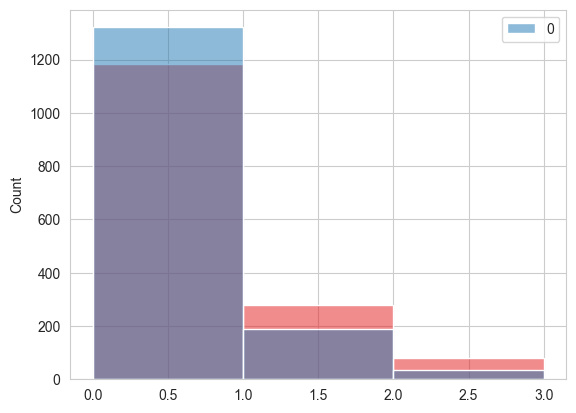

In [358]:
gene="PA1478"
sns.histplot(pd.DataFrame(data_null_gen[:, gene].X), palette="Set1", binwidth=1)
sns.histplot(pd.DataFrame(data_gene[:, gene].layers["counts"].toarray()), palette="tab10", binwidth=1)
plt.show()

In [343]:
data_gene[:, "PA4244"].layers["counts"]

<1544x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1534 stored elements in Compressed Sparse Row format>

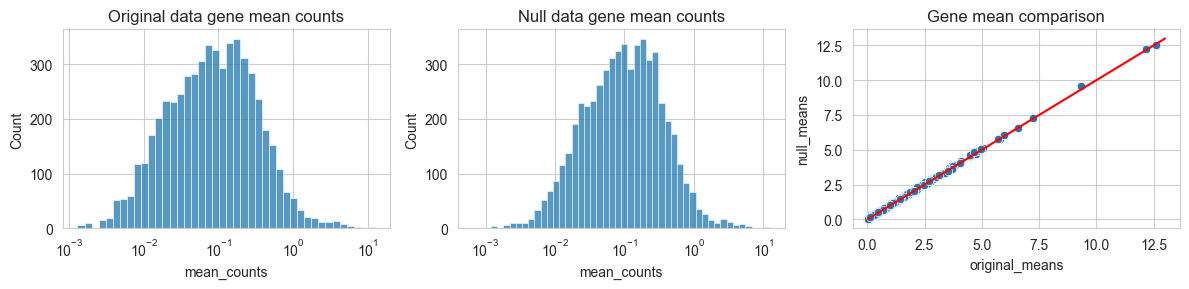

In [316]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df = pd.DataFrame({"original_means": data_gene.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

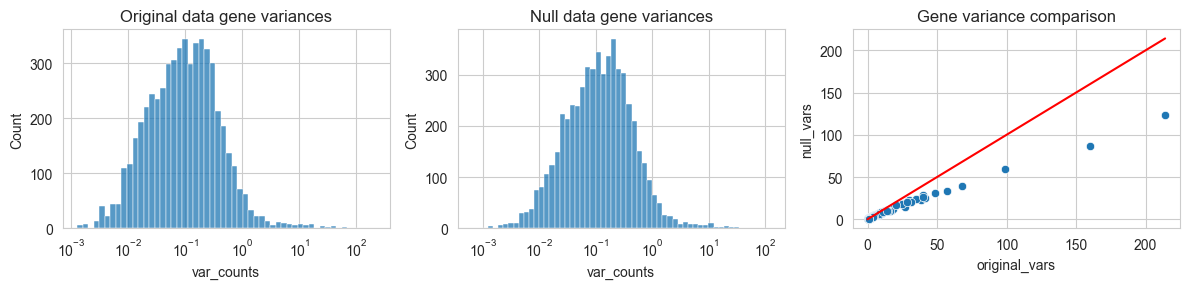

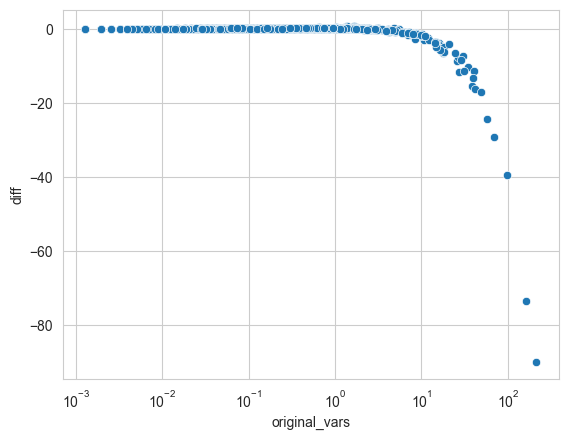

In [357]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df = pd.DataFrame({"original_vars": data_gene.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df["ratio"] = var_df["null_vars"] / var_df["original_vars"]
var_df["diff"] = var_df["null_vars"] - var_df["original_vars"]

sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

g = sns.scatterplot(var_df, x="original_vars", y="diff")
g.set(xscale="log")
plt.show()

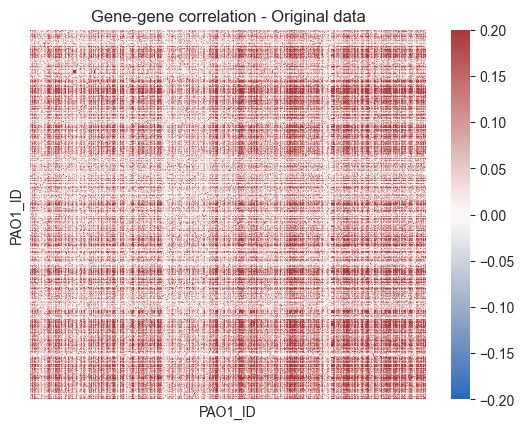

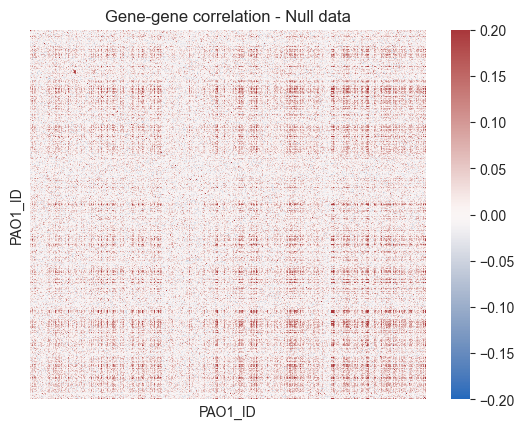

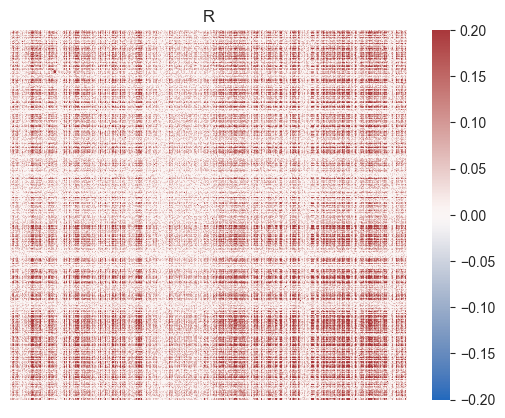

In [320]:
cor_orig = np.corrcoef(data_gene.layers["counts"].toarray().T)
cor_orig = pd.DataFrame(cor_orig, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen = np.corrcoef(data_null_gen.X.T)
cor_gen = pd.DataFrame(cor_gen, index=data_gene.var_names, columns=data_gene.var_names)

sns.heatmap(cor_orig,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Original data")
plt.show()

sns.heatmap(cor_gen,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Null data")
plt.show()

sns.heatmap(R_est,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("R")
plt.show()

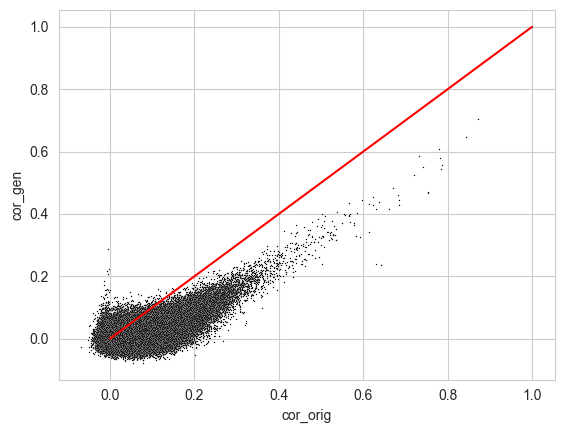

In [319]:
# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_orig": cor_orig.values.flatten(), "cor_gen": cor_gen.values.flatten(), "cor_null": cor_gen.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_orig", y="cor_gen", s=1, color="black")
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()